In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sem import SEM, EdwardNN0, LinearDynamicSystem

Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


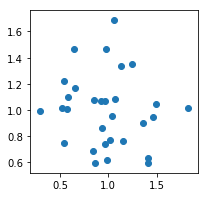

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(30)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

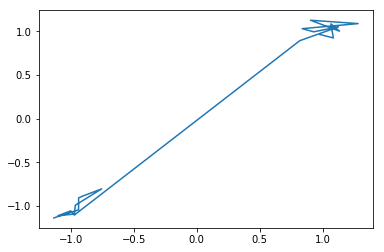

In [8]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_static_dataset(20, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

First, do the segementation with a linear dynamical system (pure python)

In [9]:
K = 20  # maximum number of event types
lmda = 10  # stickyness parameter
alfa = 1.0  # concentration parameter
beta = 0.01 # transition noise
eta =  0.1  # learning rate

sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))

sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)

Widget Javascript not detected.  It may not be installed or enabled properly.


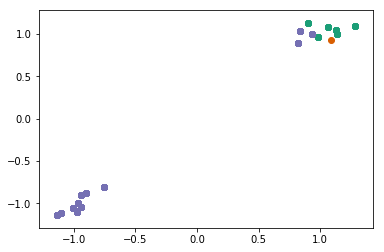

In [10]:
def plot_segmentation(post):
    cluster_id = np.argmax(post, axis=1)
    import seaborn as sns
    cc = sns.color_palette('Dark2', post.shape[1])
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        plt.scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt])
        
plot_segmentation(post)

Now, with a neural net model in Edward, where the event model $f({\bf x}_s; \theta)$ is defined to be a feed-forward neural network with one hidden layer:

$f({\bf x}_{s}; \theta)\sim N({\bf x}_{s'}; \bar \mu, {\bf I}\bar \sigma)$

$\bar \mu = {\bf h}^{\text{T}}{\bf W}_\mu + {\bf b}_\mu $

$\bar \sigma = \text{softplus} \left ({\bf h}^{\text{T}}{\bf W} + {\bf b}_\sigma \right )$

${\bf h} = {\bf x}^{\text{T}}{\bf W}_h + {\bf b}_h$

and where 
$\theta = ({\bf W}_h, {\bf b}_h, {\bf W}_\mu, {\bf b}_\mu, {\bf W}_\sigma, {\bf b}_\sigma)$

In [11]:
K = 20  # maximum number of event types
lmda = 20  # stickyness parameter
alfa = 0.50  # concentration parameter
beta = 0.01 # transition noise

# Initialize edward model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=EdwardNN0, f_opts=dict())

sem2 = SEM(**sem_kwargs)
post = sem2.run(x_train, K=K)

Widget Javascript not detected.  It may not be installed or enabled properly.



1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -13.575
1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -6.3980s | L
1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -8.629
1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -10.296 0s | Lo
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -8.639
1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: -9.420
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -2.953
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -8.4980s | Loss: -8
1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -9.0980s | Loss
1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -8.266
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -9.290
1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -18.946
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s 

sem.py:368: RuntimeWarning: divide by zero encountered in log
  LL = np.log(multivariate_normal.pdf(Y - Y_hat, mean=np.zeros(self.D), cov=Sigma))


1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -25.720
1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -24.782
1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 12.669
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 11.256
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -25.149
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -30.432
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -26.322


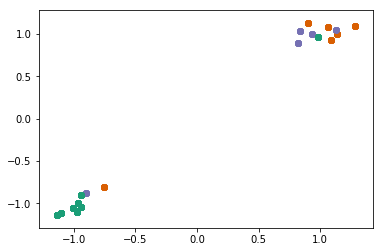

In [12]:
plot_segmentation(post)

In [13]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0])

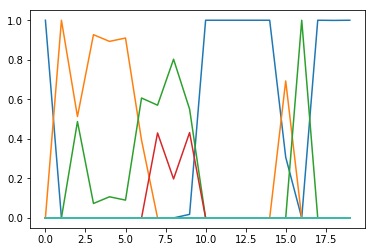

In [14]:
plt.plot(post)
plt.show()

Now, alternative between two events


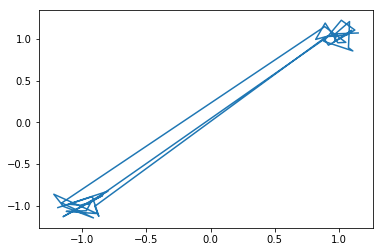

In [17]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(40, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

In [18]:
post = sem.run(x_train, K=K)

Widget Javascript not detected.  It may not be installed or enabled properly.


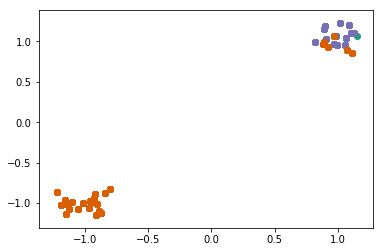

In [19]:
plot_segmentation(post)

In [20]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([0, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
post = sem2.run(x_train, K=K)

Widget Javascript not detected.  It may not be installed or enabled properly.


1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -13.191
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -3.440
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -1.322
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 1.086
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -3.358
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -4.371
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -4.226
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -2.900
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -3.670
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -6.021
1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -11.789
1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: -19.323
1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: -10.543
1000/1000 [100%] █████

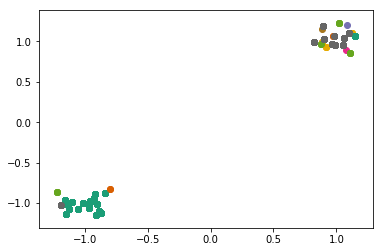

In [22]:
plot_segmentation(post)

In [23]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([0, 1, 2, 3, 4, 4, 4, 5, 5, 5, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7])

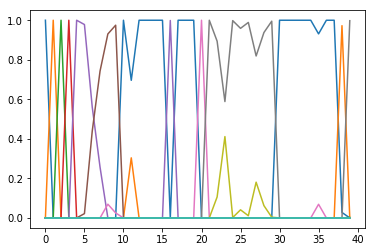

In [24]:
plt.plot(post)
plt.show()

Below an example of two events where the events correspond to movement in vector space

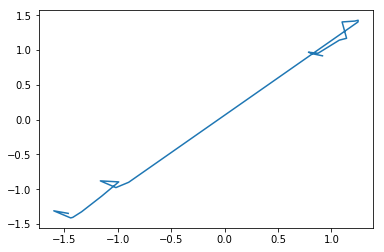

In [25]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(20)
plt.plot(x_train[:, 0], x_train[:, 1])

In [26]:
post = sem.run(x_train, K=K)

Widget Javascript not detected.  It may not be installed or enabled properly.


sem.py:647: RuntimeWarning: divide by zero encountered in log
  return np.log(multivariate_normal.pdf(Y - Y_hat, mean=np.zeros(self.D), cov=Sigma))


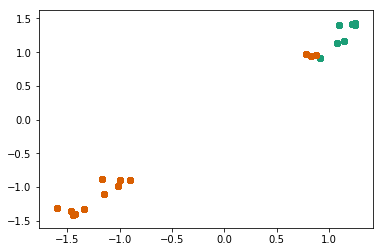

In [27]:
plot_segmentation(post)

In [28]:
np.argmax(post, axis=1)

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [29]:
post = sem2.run(x_train, K=K)

Widget Javascript not detected.  It may not be installed or enabled properly.


1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -9.572
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -0.621
1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: -3.725
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -2.744
1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: -1.088
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -9.701
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -8.618
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -8.506
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -0.547
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -1.256
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -12.348
1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: -16.274
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -17.363
1000/1000 [100%] █████

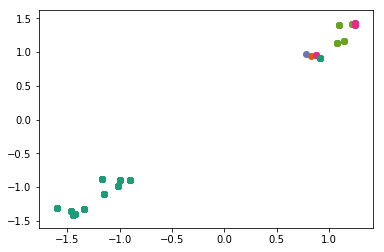

In [30]:
plot_segmentation(post)

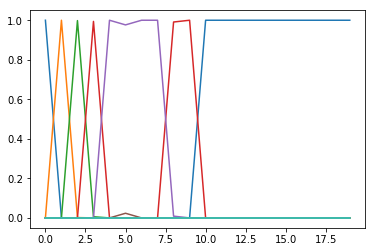

In [31]:
plt.plot(post)
plt.show()

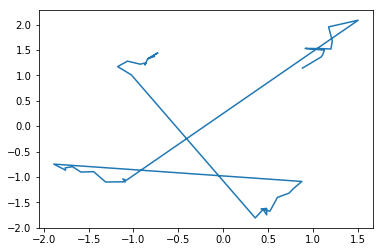

In [32]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(40)
plt.plot(x_train[:, 0], x_train[:, 1])

In [33]:
post = sem.run(x_train, K=K)

Widget Javascript not detected.  It may not be installed or enabled properly.


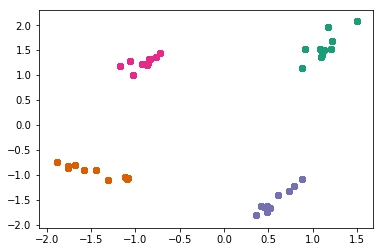

In [34]:
plot_segmentation(post)

In [35]:
np.argmax(post, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [36]:
post = sem2.run(x_train, K=K)

Widget Javascript not detected.  It may not be installed or enabled properly.


1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -10.701
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -0.782
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -11.307 1s
1000/1000 [100%] ██████████████████████████████ Elapsed: 10s | Loss: -12.885
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -9.269
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -12.069 0s | Los
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -14.054
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -13.408
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -10.695 0s | Loss: -10
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -4.789
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -9.039
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -20.025
1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Lo

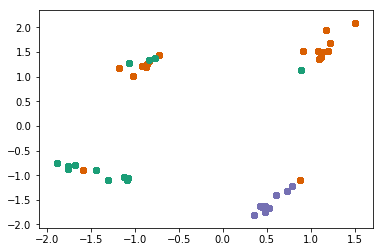

In [37]:
plot_segmentation(post)

In [38]:
np.argmax(post, axis=1)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0])

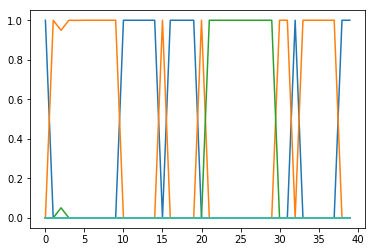

In [39]:
plt.plot(post)
plt.show()

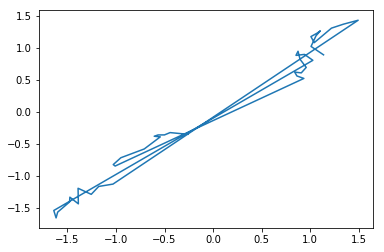

In [40]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(40)
plt.plot(x_train[:, 0], x_train[:, 1])

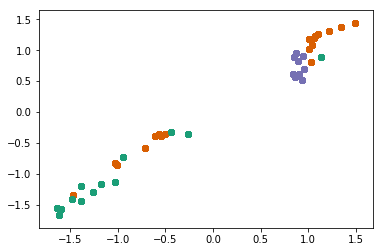

In [41]:
plot_segmentation(post)

In [42]:
post = sem2.run(x_train, K=K)

Widget Javascript not detected.  It may not be installed or enabled properly.


1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -19.167
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -4.7560s | Loss ETA: 0s | Loss: -4
1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: -6.627
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -8.070
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -11.611
1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: -14.637
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -18.038
1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: -15.588
1000/1000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: -12.871
1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: -9.792
1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: -10.229
1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: -17.114
1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Lo

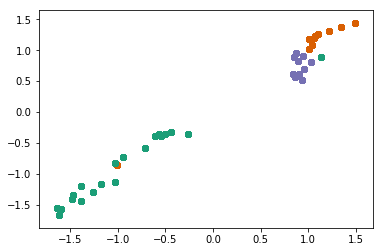

In [43]:
plot_segmentation(post)

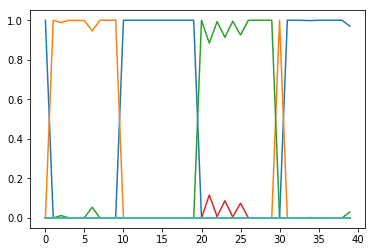

In [44]:
plt.plot(post)
plt.show()